In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.cluster import KMeans

In [ ]:
# Read Data
df = pd.read_csv ("/content/drive/MyDrive/transaction_data_2.csv")

In [ ]:
# Convert Str to DateTime
df["TransactionTime_V2"] =  pd.to_datetime(df["TransactionTime_V2"], format= '%Y-%m-%d %H:%M:%S')

In [ ]:
# Get Date Time Present
timestamp = pd.Timestamp.now()
# Remove data Negative UserId
df_not_negative = df[df["UserId"] > 0]
# Get data before Now
df_customers = df_not_negative[df_not_negative["TransactionTime_V2"]<timestamp]

In [ ]:
# Calculate TotalPay
df_customers["TotalPay"] = df_customers["NumberOfItemsPurchased"] * df_customers["CostPerItem"]
# Calculate R, F, M
df_RFM = df_customers.groupby(["UserId"]).agg(
    {
        "TransactionTime_V2": lambda x: (timestamp - x.max()).days,
        "TransactionId": "count",
        "TotalPay": "sum"
    }
)
df_RFM.rename(columns={"TransactionTime_V2":"Recency", "TransactionId":"Frequency", "TotalPay":"Monetary"}, inplace = True)

<ipython-input-32-b0870fff31e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_customers["TotalPay"] = df_customers["NumberOfItemsPurchased"] * df_customers["CostPerItem"]


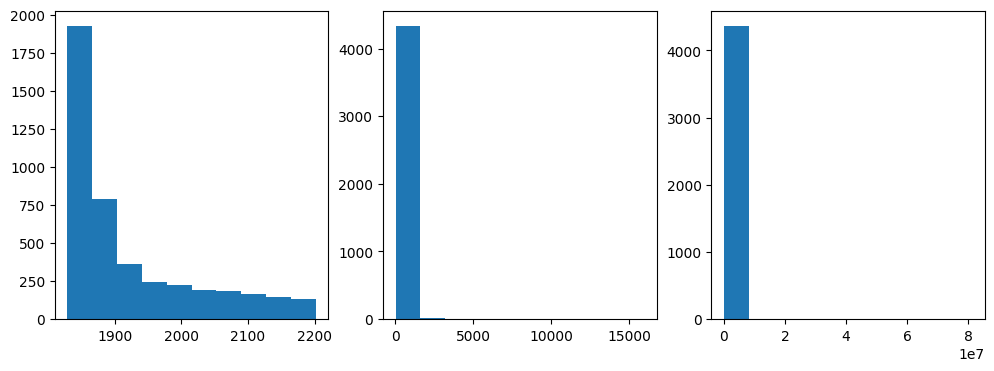

In [ ]:
# Matplolib correlation RFM
fig, ax= plt.subplots(1,3, figsize=(12,4))
ax[0].hist(df_RFM["Recency"])
ax[1].hist(df_RFM["Frequency"])
ax[2].hist(df_RFM["Monetary"])
plt.show()

In [ ]:
from scipy import stats
def analyze_skewness(x):
  fig, ax = plt.subplots(2, 2, figsize=(5, 5))
  sns.distplot(df_RFM[x], ax=ax[0, 0])
  sns.distplot(np.log(df_RFM[x]), ax=ax[0, 1])
  sns.distplot(np.sqrt(df_RFM[x]), ax=ax[1, 0])
  sns.distplot(stats.boxcox(df_RFM[x])[0], ax=ax[1, 1])
  plt.tight_layout()
  plt.show()

  print(df_RFM[x].skew().round(2))
  print(np.log(df_RFM[x]).skew().round(2))
  print(np.sqrt(df_RFM[x]).skew().round(2))
  print(pd.Series(stats.boxcox(df_RFM[x])[0]).skew().round(2))

In [ ]:
# Transform Data
df_RFM_t = pd.DataFrame()
df_RFM_t["Recency"] = np.log(df_RFM["Recency"])
df_RFM_t["Frequency"] = np.log(df_RFM["Frequency"])
df_RFM_t["Monetary"] = pd.Series(np.cbrt(df_RFM["Monetary"])).values
df_RFM_t.head(10)

,Recency,Frequency,Monetary
UserId,,,
259266,7.675082,1.386294,0.000000
259287,7.512618,5.710427,31.022654
259308,7.551712,4.127134,24.641848
259329,7.521318,4.983607,24.425200
259350,7.668094,3.526361,14.051511
259392,7.531016,5.247024,23.399839
259413,7.617268,2.079442,9.036886
259434,7.630947,4.753590,20.769266
259455,7.622175,3.258097,15.620715


In [ ]:
# Scale Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_RFM_t)

df_RFM_t = scaler.transform(df_RFM_t)

In [ ]:
pd.DataFrame(df_RFM_t)

,0,1,2
0,2.289920,-2.230847,-1.647482
1,-0.912386,0.995099,0.963885
2,-0.141798,-0.186090,0.426773
3,-0.740894,0.452867,0.408537
4,2.152178,-0.634287,-0.464680
...,...,...,...
4362,1.845714,-1.030153,-0.684485
4363,0.916282,-1.296244,-0.911059
4364,-0.858634,-0.834421,-0.691220
4365,-0.901624,2.196781,0.533351


In [ ]:
_# Cluster data by KMean Elbow
sse = {}
for k in range (1,11):
  kmeans = KMeans(n_clusters= k, random_state = 42)
  kmeans.fit(df_RFM_t)
  sse[k] = kmeans.inertia_

plt.title('The Elbow Method')
plt.xlabel('K Means')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [ ]:
  model = KMeans(n_clusters= 4, random_state = 42)
  model.fit(df_RFM_t)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=42)

In [ ]:
df_RFM["Cluster"] = model.labels_
df_RFM.head()

,Recency,Frequency,Monetary,Cluster
UserId,,,,
259266,2154,4,0.00,1
259287,1831,302,29856.36,2
259308,1904,62,14963.04,0
259329,1847,146,14571.84,2
259350,2139,34,2774.40,1


In [ ]:
df_RFM.groupby("Cluster").agg(
    {
        "Recency": "mean",
        "Frequency": "mean",
        "Monetary": "mean"
    }
).round(2)

,Recency,Frequency,Monetary
Cluster,,,
0,1881.64,71.96,5086.56
1,2080.86,43.55,2916.40
2,1858.06,461.13,40915.62
3,2202.00,2.00,81421701.12


In [ ]:
# Conclusion
# Dữ liệu phân ra thành 4 cụm khách hàng gồm
# + Cụm 0:
# Các khách hàng mới mua hàng gần đây
# Tần xuất mua hàng trung bình
# Tổng giá trị mua hàng trung bình
# => Các khách hàng mới

# + Cụm 1:
# Các khách hàng đã mua hàng từ rất lâu
# Tần xuất mua hàng thấp
# Tổng giá trị đơn hàng vừa phải
# => Là các khách hàng cũ nhưng thời gian gần đây không mua hàng nữa, cần chăm sóc lại

# + Cụm 2:
# Các khách hàng mua hàng gần đây nhất
# Tần suất mua hàng thường xuyên
# Giá trị đơn hàng lớn
# => Là các khách hàng mới và đang có phản hồi tích cực (tệp khách trung thành), cần chăm sóc và đưa ra các ưu đãi để duy trì

# + Cụm 3:
# Các khách hàng mua hàng từ rất lấu
# Tần suất mua hàng không thường xuyên nữa
# Giá trị đơn hàng lớn
# => Là các khách hàng cũ hoặc mua sỉ đã từng mua hàng rất nhiều nhưng không mua nữa vào thời gian gần đây, cần chăm sóc lại để tìm ra nguyên nhân

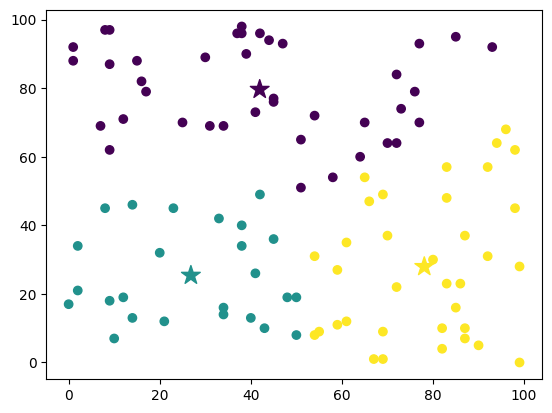

In [ ]:
# Kmeans Clustering From Scratch
class KMeansCluster:
  def __init__ (self, k=3):
    self.k= k
    self.centroids = None

  def euclidean_distance(data_point, centroids):
    return np.sqrt(np.sum((centroids - data_point)**2, axis = 1))

  def fit (self, x, max_interations = 200):
    self.centroids = np.random.uniform(np.amin(x, axis = 0), np.amax(x, axis = 0), size = (self.k, x.shape[1]))

    for a in range(max_interations):
      y = []
      for data_point in x:
        distances = KMeansCluster.euclidean_distance(data_point, self.centroids)
        cluster_num = np.argmin(distances)
        y.append(cluster_num)

      y = np.array(y)

      cluster_indices = []

      for i in range(self.k):
        cluster_indices.append(np.argwhere(y == i))

      cluster_centers = []

      for i, indices in enumerate(cluster_indices):
        if len(indices) == 0:
          cluster_centers.append(self.centroids[i])
        else:
          cluster_centers.append(np.mean(x[indices], axis = 0)[0])

      if np.max(self.centroids - np.array(cluster_centers)) < 0.0001:
        break
      else:
        self.centroids = np.array(cluster_centers)

    return y

random_points = np.random.randint(0, 100, (100,2))
kmeans = KMeansCluster(k=3)
labels = kmeans.fit(random_points)

plt.scatter(random_points[:, 0], random_points[:, 1], c = labels)
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c = range(len(kmeans.centroids)),
            marker = '*', s = 200)
plt.show()
